In [1]:
import pandas as pd
import os, re
import csv

In [2]:
# Change the work directory to the parent
try:
    if chdir:
        pass
except:
    current_dir = os.getcwd()
    os.chdir(current_dir +"/..")
    os.path.abspath(os.curdir)

In [3]:
chdir = True

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [5]:
# Metadata for specific SFC configurations
exp_fr = "fixed_rate_7500"

vnfs = ["firewall.csv", "nf_router.csv", "ndpi_stats.csv", "payload_scan.csv", "bridge.csv"]

In [6]:
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []

    if file.startswith("latency.csv"):
        with open(os.path.join("..\\linear\\data", exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "fixed_rate" else f.readlines()
            for line in lines:
                try:
                    value = float(line.strip()) / 1000
                except ValueError:
                    value = "N/A"
                tmp.append(value)
    else:
        with open(os.path.join("..\\linear\\data", exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                try:
                    value = float(l.strip().split(",")[index])
                except ValueError:
                    value = "N/A"
                tmp.append(value)

    return tmp


In [7]:
def parse_reg(exp_type, exp_num, file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join("..\\linear\\data", exp_type, exp_num, file)) as file:
        for line in file:
            if re.search(stat_name, line):
                try:
                    value = float(line.strip().split(',')[index])
                except ValueError:
                    value = "N/A"
                stat.append(value)

    return stat


In [8]:
latency = parse_seq("fixed_rate", exp_fr, "latency.csv")
len(latency)

7188

In [9]:
tx_stats = parse_seq("fixed_rate", exp_fr, "tx_stats.csv")
len(tx_stats)

7189

In [10]:
rx_stats = parse_seq("fixed_rate", exp_fr, "rx_stats.csv")
len(rx_stats)

7189

In [11]:
firewall_instructions = parse_reg("fixed_rate", exp_fr, "firewall.csv", "instructions", 1)
len(firewall_instructions)

7186

In [12]:
features = ["instructions", "branches,", "branch-misses,", "branch-load-misses,", "cache-misses", \
            "cache-references", ",cycles,", "L1-dcache-load-misses", "L1-dcache-loads", "LLC-load-misses", \
            "LLC-stores", "LLC-loads",]

In [13]:
def make_df():
    tmp = []
    dic = dict()
    
    tx_stats = parse_seq("fixed_rate", exp_fr, "tx_stats.csv")
    rx_stats = parse_seq("fixed_rate", exp_fr, "rx_stats.csv")
    
    latency = parse_seq("fixed_rate",exp_fr, "latency.csv")
 
    
    seq_length = min([len(parse_reg("fixed_rate", exp_fr, "firewall.csv", "instructions", 1)), \
                          len(tx_stats), \
                          len(rx_stats), \
                          len(latency)])
    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]
    
    for f in features:
        for v in vnfs:
            tmp = parse_reg("load_stimulus", exp_fr, v, f, 1)
            
            dic[v.split(".")[0]+"_"+f.replace(",","")] = tmp[:seq_length]
            
    return pd.DataFrame(dic)

In [14]:
def make_df():
    tmp = []
    dic = dict()
    
    tx_stats = parse_seq("fixed_rate", exp_fr, "tx_stats.csv")
    rx_stats = parse_seq("fixed_rate", exp_fr, "rx_stats.csv")
    latency = parse_seq("fixed_rate", exp_fr, "latency.csv")

    seq_length = min(len(parse_reg("fixed_rate", exp_fr, "firewall.csv", "instructions", 1)), len(tx_stats), len(rx_stats), len(latency))
    
    # Get data for each feature and VNF
    for f in features:
        for v in vnfs:
            tmp = parse_reg("fixed_rate", exp_fr, v, f, 1)
            if len(tmp) < seq_length:
                tmp += ["N/A"] * (seq_length - len(tmp))  # Add "N/A" values if list is too short
            dic[v.split(".")[0] + "_" + f.replace(",", "")] = tmp[:seq_length]

    # Add remaining data to dictionary
    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]
    
    return pd.DataFrame(dic)


In [15]:
df = make_df()

<Axes: >

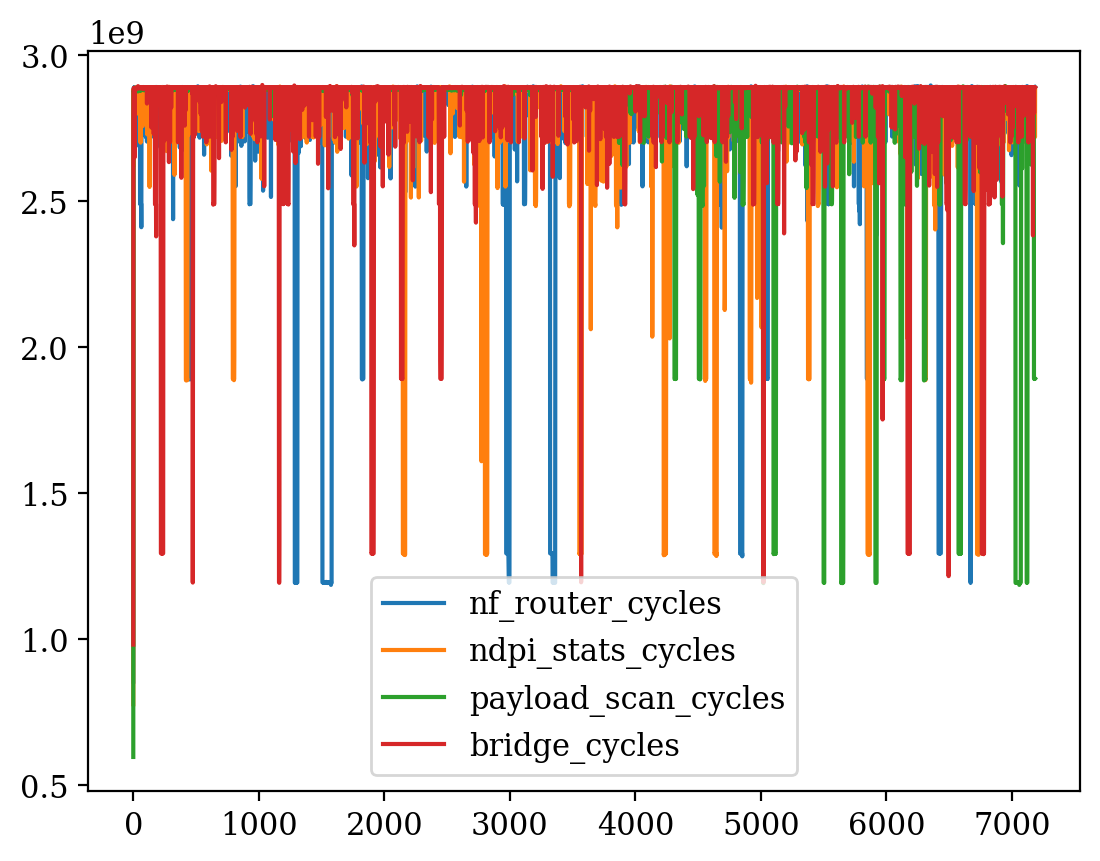

In [16]:
df[["firewall_cycles","nf_router_cycles","ndpi_stats_cycles","payload_scan_cycles","bridge_cycles"]].plot()

<Axes: >

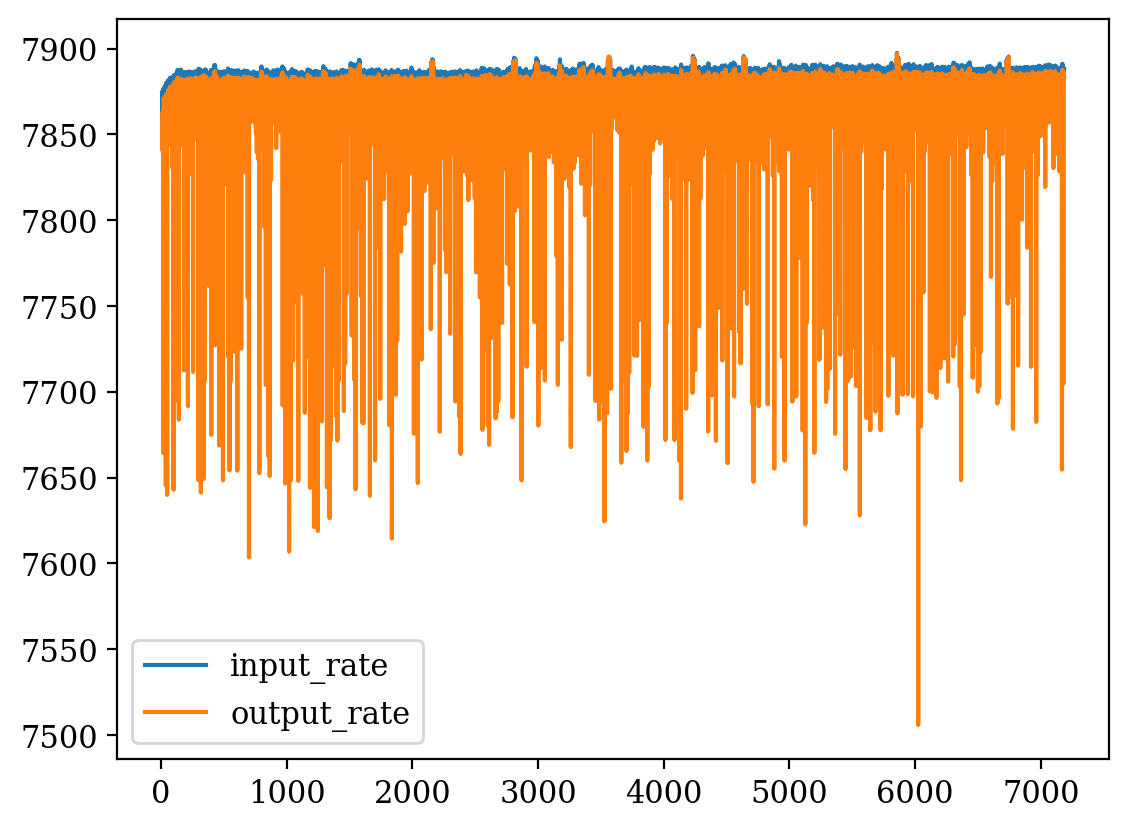

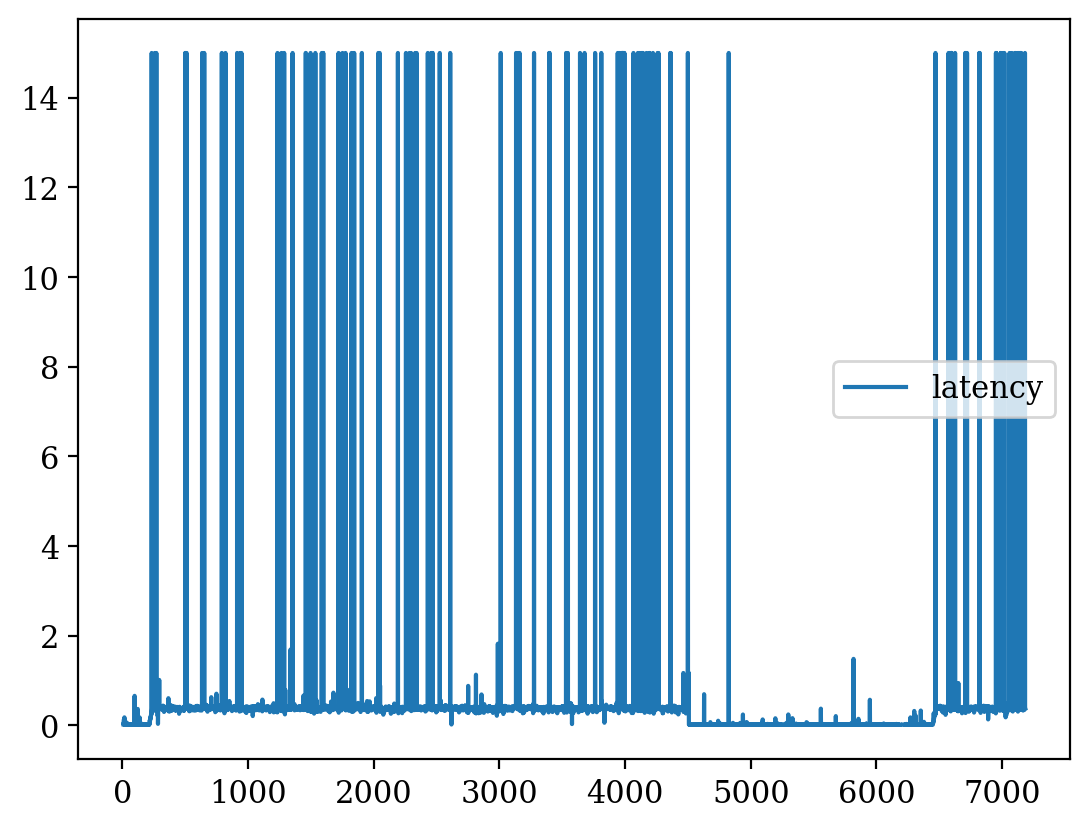

In [17]:
df[["input_rate", "output_rate"]][10:].plot()
df[["latency"]][10:].divide(1000).plot()


In [18]:
abs_path = os.path.join("..\\linear\\datasets", "load_stimulus_"+ exp_fr +".csv")
df.to_csv(abs_path, sep=',')


In [19]:
# delete N/A, and delete the first column

def process_csv(input_file, output_file, fixed_input_rate):
    # Read CSV file into a DataFrame
    df = pd.read_csv(input_file)
    
    # Drop the first column
    df = df.drop(df.columns[0], axis=1)
    
    # Drop the first two rows
    df = df.iloc[2:]
    
    # Drop the last row
    df = df.iloc[:-1]
    
    # Set the "input_rate" column to a fixed value
    df["input_rate"] = fixed_input_rate
    
    # Write the processed DataFrame to a new CSV file
    abs_path = os.path.join("..\\linear\\datasets", "load_stimulus_"+ exp_fr +"_modified"+".csv")
    df.to_csv(abs_path, sep=',')   
    
    
process_csv("..\\linear\\datasets\\load_stimulus_fixed_rate_7500.csv", "..\\linear\\datasets\\load_stimulus_fixed_rate_7500_modified.csv", 7500)